<h1 style="color: green;">Google Play Store App Data Insights Analysis - Pyspark & Pandas</h1>

Peng, 29 May 2025


<h2 style="color: green;">Step 1: Import libraries and initiate spark session</h2>


In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
spark = SparkSession.builder.appName("project1").getOrCreate()

25/05/29 10:32:56 WARN Utils: Your hostname, Pengs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.7 instead (on interface en0)
25/05/29 10:32:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/29 10:32:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<h2 style="color: green;">Step 2: Ingest Data</h2>


In [2]:
df_spark = spark.read.csv(
    "/Users/pengwang/Documents/Data Engineering Projects/googleplaystore.csv",
    header=True,inferSchema=True)

print(f'There are {df_spark.count()} rows')
print()

df_spark.show(2,truncate=False)


There are 10841 rows

+----------------------------------------------+--------------+------+-------+----+--------+----+-----+--------------+-------------------------+----------------+-----------+------------+
|App                                           |Category      |Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres                   |Last Updated    |Current Ver|Android Ver |
+----------------------------------------------+--------------+------+-------+----+--------+----+-----+--------------+-------------------------+----------------+-----------+------------+
|Photo Editor & Candy Camera & Grid & ScrapBook|ART_AND_DESIGN|4.1   |159    |19M |10,000+ |Free|0    |Everyone      |Art & Design             |January 7, 2018 |1.0.0      |4.0.3 and up|
|Coloring book moana                           |ART_AND_DESIGN|3.9   |967    |14M |500,000+|Free|0    |Everyone      |Art & Design;Pretend Play|January 15, 2018|2.0.0      |4.0.3 and up|
+------------------------------------------

<h2 style="color: green;">Step 3: Data Cleaning</h2>
1)Drop null & NaN rows <br>2)Convert data types for each col <br>3)Remove leading/trailing quotes and spaces for all cols <br>4)Process duplicated rows via groupby <br>5)Convert 'Last Updated' col into date format


<h3 style="color: #FFD700;">1) Drop null & NaN rows</h3>

In [3]:
def check_null_and_nan_counts(df):
    """Count both null and NaN values for each column"""
    null_nan_exprs = []
    
    for c in df.columns:
        col_type = df.schema[c].dataType
        if isinstance(col_type, (DoubleType, FloatType)):
            # For numeric columns, check both null and NaN
            expr = (F.sum(F.col(c).isNull().cast("int")) + 
                   F.sum(F.isnan(F.col(c)).cast("int"))).alias(c)
        else:
            # For non-numeric columns, check only null
            expr = F.sum(F.col(c).isNull().cast("int")).alias(c)
        null_nan_exprs.append(expr)
    return df.agg(*null_nan_exprs)

# Check both null and NaN counts
check_null_and_nan_counts(df_spark).show()


#As the null rows are minimal, will simply drop them
df_spark = df_spark.dropna(how='any')

# Drop rows with NaN values in numeric columns
numeric_cols = [c for c, dtype in df_spark.dtypes if dtype in ['double', 'float']]
for col in df_spark.columns:
    df_spark = df_spark.filter(~F.isnan(F.col(col)))
    
check_null_and_nan_counts(df_spark).show()
print()
print(f'There are {df_spark.count()} rows')

df_spark.show(5, truncate=False)


+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   0|       0|   0|    0|             1|     0|           0|          1|          1|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   0|       0|   0|    0|             0|     0|           

<h3 style="color: #FFD700;">2) Convert data types for each col</h3>

In [4]:
# Original Schema
df_spark.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



<span style="color: #FFD700;">**col - 'Price'**</span>

In [5]:
df_spark.select('Price').filter(
    ~F.col('Price').rlike('^[0-9]+(\\.?[0-9]*)?$') &       # Not pure numbers  
    ~F.col('Price').rlike('^\\$[0-9]+(\\.?[0-9]*)?$')       # Not $ format
).distinct().show(1000, truncate=False)

+------------------+
|Price             |
+------------------+
|5.0M              |
|Varies with device|
+------------------+



In [6]:
df_spark.filter(F.col('Price')=='5.0M').show()

+--------------------+--------+------+-------------+------------------+--------+----+-----+--------------+------+------------+-----------+----------------+
|                 App|Category|Rating|      Reviews|              Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|     Android Ver|
+--------------------+--------+------+-------------+------------------+--------+----+-----+--------------+------+------------+-----------+----------------+
|"Women""s Health ...|    Face|  Body|weight lose)"|HEALTH_AND_FITNESS|     4.2|2509| 5.0M|    1,000,000+|  Free|           0| Mature 17+|Health & Fitness|
+--------------------+--------+------+-------------+------------------+--------+----+-----+--------------+------+------------+-----------+----------------+



In [7]:
# For Price col, remove $ M sign and convert unit for fields contains 'M' into Million
df_spark = df_spark.withColumn('Price', F.regexp_replace(F.col('Price'), '\\$', ''))

# Handle 'M' suffix - convert to actual millions
df_spark = df_spark.withColumn('Price', 
    F.when(F.col('Price').endswith('M'), 
         F.regexp_replace(F.col('Price'), 'M', '').cast('float') * 1000000)
    .when(F.col('Price') == 'Varies with device', F.lit('Varies with device'))  # Keep as string
    .otherwise(F.col('Price').cast('float'))
)

In [8]:
df_spark.filter(F.col('Price')==5000000).show()

+--------------------+--------+------+-------------+------------------+--------+----+---------+--------------+------+------------+-----------+----------------+
|                 App|Category|Rating|      Reviews|              Size|Installs|Type|    Price|Content Rating|Genres|Last Updated|Current Ver|     Android Ver|
+--------------------+--------+------+-------------+------------------+--------+----+---------+--------------+------+------------+-----------+----------------+
|"Women""s Health ...|    Face|  Body|weight lose)"|HEALTH_AND_FITNESS|     4.2|2509|5000000.0|    1,000,000+|  Free|           0| Mature 17+|Health & Fitness|
+--------------------+--------+------+-------------+------------------+--------+----+---------+--------------+------+------------+-----------+----------------+



In [9]:
df_spark.select('Price').filter(
    ~F.col('Price').rlike('^[0-9]+(\\.?[0-9]*)?$') &       # Not pure numbers  
    ~F.col('Price').rlike('^\\$[0-9]+(\\.?[0-9]*)?$')       # Not $ format
).distinct().show(1000, truncate=False)

+------------------+
|Price             |
+------------------+
|Varies with device|
+------------------+



<span style="color: #FFD700;">**col - 'Reviews'**</span>

In [10]:
# Find rows where Reviews doesn't match pure numbers
Weird_rows_Reviews = df_spark.select('Reviews').filter(~F.col('Reviews').rlike('^[0-9]+$')).distinct()
Weird_rows_Reviews.show()
Weird_rows_Reviews_List = [row['Reviews'] for row in Weird_rows_Reviews.collect()]
Weird_rows_Reviews_List

# Drop the rows contains values from Weird_rows_Reviews_List
df_spark = df_spark.filter(~F.col('Reviews').isin(Weird_rows_Reviews_List))
df_spark.show(2)

# Confirm there is no more rows contains values from Weird_rows_Reviews_List
df_spark.filter(F.col('Reviews').isin(Weird_rows_Reviews_List)).show(truncate=False)

+-------------+
|      Reviews|
+-------------+
|weight lose)"|
|      camera"|
+-------------+

+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+----------------+-----------+------------+
|                 App|      Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|              Genres|    Last Updated|Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+----------------+-----------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M| 10,000+|Free|  0.0|      Everyone|        Art & Design| January 7, 2018|      1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|500,000+|Free|  0.0|      Everyone|Art & Design;Pret...|January 15, 2018|      2.0.0|4.0.3 and up|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+--------------------+----------

<span style="color: #FFD700;">**col - 'Rating'**</span>

In [11]:
df_spark.filter(~F.col('Rating').rlike('^[0-9]+(\\.?[0-9]*)?$')).show(50, truncate=False)

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



In [12]:
# Convert Schema into appropriate type for each col

numeric_cols = ['Rating', 'Reviews', 'Price']
df_spark = df_spark.withColumns({c: F.col(c).cast(DoubleType()) for c in numeric_cols})
df_spark = df_spark.withColumn('Reviews', F.col('Reviews').cast(IntegerType()))
df_spark.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [13]:
df_spark.show(5, truncate=False)

+--------------------------------------------------+--------------+------+-------+----+-----------+----+-----+--------------+-------------------------+----------------+------------------+------------+
|App                                               |Category      |Rating|Reviews|Size|Installs   |Type|Price|Content Rating|Genres                   |Last Updated    |Current Ver       |Android Ver |
+--------------------------------------------------+--------------+------+-------+----+-----------+----+-----+--------------+-------------------------+----------------+------------------+------------+
|Photo Editor & Candy Camera & Grid & ScrapBook    |ART_AND_DESIGN|4.1   |159    |19M |10,000+    |Free|0.0  |Everyone      |Art & Design             |January 7, 2018 |1.0.0             |4.0.3 and up|
|Coloring book moana                               |ART_AND_DESIGN|3.9   |967    |14M |500,000+   |Free|0.0  |Everyone      |Art & Design;Pretend Play|January 15, 2018|2.0.0             |4.0.3 and

<h3 style="color: #FFD700;">3) Remove leading/trailing quotes and spaces for all cols</h3>

In [14]:
# Remove leading/trailing quotes and spaces for all cols
for col in df_spark.columns:
    df_spark_cleaned = df_spark.withColumn(col, F.trim(F.regexp_replace(col, '^[" ]+|[" ]+$', '')))


<h3 style="color: #FFD700;">4) Process duplicated rows via groupby</h3>

In [15]:

# Process duplicated rows via groupby
df_spark_grouped = df_spark_cleaned.groupBy('App', 'Current Ver', 'Type', 'Last Updated').agg(

    F.first('Category').alias('Category'),
    F.mean('Rating').alias('Rating'),
    F.sum('Reviews').alias('Reviews'),
    F.first('Size').alias('Size'), # There is no duplication
    F.first('Installs').alias('Installs'), # There is only one duplicated Installs row, so it's safe to use 'first'
    F.first('Price').alias('Price'),
    F.first('Content Rating').alias('Content Rating'),
    F.first('Genres').alias('Genres'),
    F.first('Android Ver').alias('Android Ver')
)

df_spark_grouped.show(5, truncate=False)

print()
print(f'There are {df_spark_grouped.count()} rows')

+---------------------------------------+------------------+----+-----------------+---------------+------+-------+------------------+----------+-----+--------------+---------------+------------------+
|App                                    |Current Ver       |Type|Last Updated     |Category       |Rating|Reviews|Size              |Installs  |Price|Content Rating|Genres         |Android Ver       |
+---------------------------------------+------------------+----+-----------------+---------------+------+-------+------------------+----------+-----+--------------+---------------+------------------+
|"Alphabet ""H"" Passcode Lock Screen"  |1.0               |Free|December 21, 2017|PERSONALIZATION|4.5   |2      |3.0M              |100+      |0.0  |Everyone      |Personalization|4.1 and up        |
|"Eat Fast Prepare ""Without Internet"""|3.6.6             |Free|June 10, 2018    |FOOD_AND_DRINK |4.6   |4925   |17M               |1,000,000+|0.0  |Everyone      |Food & Drink   |4.0.3 and up   

In [16]:
check_null_and_nan_counts(df_spark_grouped).show()
df_spark_grouped.show(2,truncate=False)

+---+-----------+----+------------+--------+------+-------+----+--------+-----+--------------+------+-----------+
|App|Current Ver|Type|Last Updated|Category|Rating|Reviews|Size|Installs|Price|Content Rating|Genres|Android Ver|
+---+-----------+----+------------+--------+------+-------+----+--------+-----+--------------+------+-----------+
|  0|          0|   0|           0|       0|     0|      0|   0|       0|    0|             0|     0|          0|
+---+-----------+----+------------+--------+------+-------+----+--------+-----+--------------+------+-----------+

+---------------------------------------+-----------+----+-----------------+---------------+------+-------+----+----------+-----+--------------+---------------+------------+
|App                                    |Current Ver|Type|Last Updated     |Category       |Rating|Reviews|Size|Installs  |Price|Content Rating|Genres         |Android Ver |
+---------------------------------------+-----------+----+-----------------+-----

<h3 style="color: #FFD700;">5) Convert 'Last Updated' col into date format</h3>

In [17]:
df_spark_grouped.select('Last Updated').distinct().show(5, truncate=False)

+-----------------+
|Last Updated     |
+-----------------+
|May 30, 2017     |
|March 2, 2017    |
|March 25, 2016   |
|October 27, 2015 |
|February 10, 2013|
+-----------------+
only showing top 5 rows



In [18]:
df_spark_grouped = df_spark_grouped.withColumn('Last Updated', F.to_date(F.col('Last Updated'), 'MMMM d, yyyy'))
df_spark_grouped.show(5,truncate=False)

+---------------------------------------+------------------+----+------------+---------------+------+-------+------------------+----------+-----+--------------+---------------+------------------+
|App                                    |Current Ver       |Type|Last Updated|Category       |Rating|Reviews|Size              |Installs  |Price|Content Rating|Genres         |Android Ver       |
+---------------------------------------+------------------+----+------------+---------------+------+-------+------------------+----------+-----+--------------+---------------+------------------+
|"Alphabet ""H"" Passcode Lock Screen"  |1.0               |Free|2017-12-21  |PERSONALIZATION|4.5   |2      |3.0M              |100+      |0.0  |Everyone      |Personalization|4.1 and up        |
|"Eat Fast Prepare ""Without Internet"""|3.6.6             |Free|2018-06-10  |FOOD_AND_DRINK |4.6   |4925   |17M               |1,000,000+|0.0  |Everyone      |Food & Drink   |4.0.3 and up      |
|"Official QR Code® 

In [19]:
df_spark_grouped.select('Last Updated').distinct().show(5, truncate=False)

+------------+
|Last Updated|
+------------+
|2018-05-28  |
|2017-08-11  |
|2015-05-19  |
|2017-09-11  |
|2016-03-01  |
+------------+
only showing top 5 rows



<h2 style="color: green;">Step 4: Exploratory Data Analysis</h2>


In [20]:
df = df_spark_grouped.toPandas()
df.head()

,App,Current Ver,Type,Last Updated,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Android Ver
0,"""Alphabet """"H"""" Passcode Lock Screen""",1.0,Free,2017-12-21,PERSONALIZATION,4.5,2,3.0M,100+,0.0,Everyone,Personalization,4.1 and up
1,"""Eat Fast Prepare """"Without Internet""""""",3.6.6,Free,2018-06-10,FOOD_AND_DRINK,4.6,4925,17M,"1,000,000+",0.0,Everyone,Food & Drink,4.0.3 and up
2,"""Official QR Code® Reader """"Q""""""",Varies with device,Free,2018-03-23,PRODUCTIVITY,4.4,3031,Varies with device,"500,000+",0.0,Everyone,Productivity,Varies with device
3,+Download 4 Instagram Twitter,5.03,Free,2018-08-02,SOCIAL,4.5,40467,22M,"1,000,000+",0.0,Everyone,Social,4.1 and up
4,- Free Comics - Comic Apps,5.0.12,Free,2018-07-13,COMICS,3.5,115,9.1M,"10,000+",0.0,Mature 17+,Comics,5.0 and up


In [21]:
df.App.nunique()

8188

In [22]:
df[df['App']=='AliExpress - Smarter Shopping, Better Living']

,App,Current Ver,Type,Last Updated,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Android Ver
523,"AliExpress - Smarter Shopping, Better Living",Varies with device,Free,2018-08-01,SHOPPING,4.6,5911055,Varies with device,"100,000,000+",0.0,Teen,Shopping,Varies with device
524,"AliExpress - Smarter Shopping, Better Living",Varies with device,Free,2018-08-06,SHOPPING,4.6,17750660,Varies with device,"100,000,000+",0.0,Teen,Shopping,Varies with device


<h3 style="color: #FFD700;">Question 1: Which categories have the most App?</h3>

Family(19.7%), Game(11.1%), Tools(8.8%), Finance(3.7%), Lifestyle(3.7%)

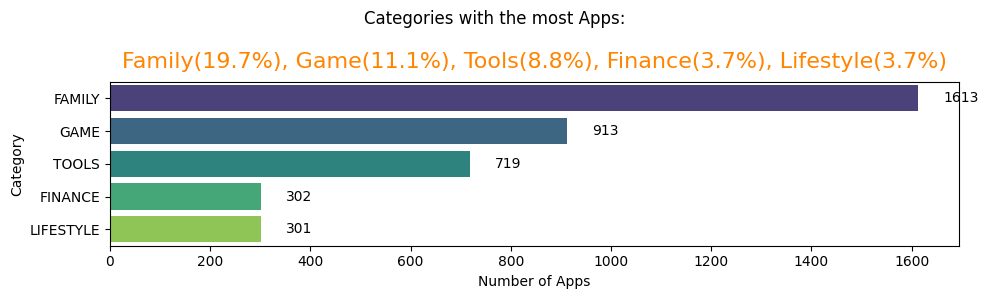

In [23]:
df_category = df.groupby('Category').App.nunique().sort_values(ascending=False).reset_index()

# Calculate percentages
total_apps = df_category['App'].sum()
df_category['Percentage'] = (df_category['App'] / total_apps * 100).round(1)

plt.figure(figsize=(10, 3))  
ax = sns.barplot(data=df_category.head(), y='Category', x='App', 
                 hue='Category', palette='viridis', legend=False)
plt.suptitle('Categories with the most Apps:', fontsize=12, y=0.98)
plt.title('Family(19.7%), Game(11.1%), Tools(8.8%), Finance(3.7%), Lifestyle(3.7%)', 
          fontsize=16, pad=10,color="#FF8400")
plt.xlabel('Number of Apps', fontsize=10)
plt.yticks(fontsize=10) 
# Add value labels 
for i, v in enumerate(df_category.head()['App']):
    ax.text(v + 50, i, str(v), va='center', fontsize=10) 

plt.tight_layout()
plt.show()

# # Print summary
# print(f"Total apps across all categories: {total_apps:,}")
# print(f"\nTop 15 categories:")
# print(df_category.head(15)[['Category', 'App', 'Percentage']])

<h3 style="color: #FFD700;">Question 2: Which categories has the average most frequent app version update?</h3>

all categories have median of 1 update 

In [24]:
df.groupby(['Category', 'App']).size().reset_index(name='Update_Count')['Update_Count'].value_counts()

Update_Count
1    8168
2      32
Name: count, dtype: int64

In [25]:
category_updates = (df.groupby(['Category', 'App']).size()
                     .reset_index(name='Update_Count')
                     .groupby('Category')['Update_Count']
                     .median()
                     .sort_values(ascending=False)
                     .reset_index()) 

print("Categories with most frequent app updates:")
print(category_updates.head())

Categories with most frequent app updates:
             Category  Update_Count
0      ART_AND_DESIGN           1.0
1  LIBRARIES_AND_DEMO           1.0
2       VIDEO_PLAYERS           1.0
3    TRAVEL_AND_LOCAL           1.0
4               TOOLS           1.0


<h3 style="color: #FFD700;">Question 3: What are the key factors deciding the installs and Rating?</h3>

1. 92.7% apps are free
2. Free apps has 100x higher installs than paid apps
3. Median rating for both paid and free apps are similar

In [26]:
df1 = df.groupby('App').last().reset_index()
df1['Installs'] = df1['Installs'].str.replace(',', '').str.replace('+', '').astype(int)
display(df1.head(2))
df_free = df1[df1['Price'] == 0]
df_paid = df1[df1['Price'] > 0]
app_summary = pd.DataFrame({'Count': df1['Type'].value_counts(), 'Percentage': (df1['Type'].value_counts(normalize=True) * 100).round(1).astype(str) + '%'})
print(app_summary)
free_app_median_install = df_free['Installs'].median()
paid_app_median_install = df_paid['Installs'].median()
print(f"Median installs for free apps: {int(free_app_median_install)}")
print(f"Median installs for paid apps: {int(paid_app_median_install)}")

free_app_median_rating = df_free['Rating'].median()
paid_app_median_rating = df_paid['Rating'].median()
print(f"Median rating for free apps: {free_app_median_rating}")
print(f"Median rating for paid apps: {paid_app_median_rating}")

# # Calculate thresholds
# bottom_threshold = df1['Rating'].quantile(0.30)
# top_threshold = df1['Rating'].quantile(0.70)

# print()

# # Bottom 30%
# bottom_30_percent = df1[df1['Rating'] <= bottom_threshold]
# print(f'\n - Worst Apps - Bottom 30% ({len(bottom_30_percent)} apps):')
# bottom_summary = pd.DataFrame({
#     'Count': bottom_30_percent['Type'].value_counts(),
#     'Percentage': bottom_30_percent['Type'].value_counts(normalize=True) * 100
# })
# print(bottom_summary.round(1))

# # Top 30%
# top_30_percent = df1[df1['Rating'] >= top_threshold]
# print(f'\n- Best Apps - Top 30% ({len(top_30_percent)} apps):')
# top_summary = pd.DataFrame({
#     'Count': top_30_percent['Type'].value_counts(),
#     'Percentage': top_30_percent['Type'].value_counts(normalize=True) * 100
# })
# print(top_summary.round(1))



,App,Current Ver,Type,Last Updated,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Android Ver
0,"""Alphabet """"H"""" Passcode Lock Screen""",1.0,Free,2017-12-21,PERSONALIZATION,4.5,2,3.0M,100,0.0,Everyone,Personalization,4.1 and up
1,"""Eat Fast Prepare """"Without Internet""""""",3.6.6,Free,2018-06-10,FOOD_AND_DRINK,4.6,4925,17M,1000000,0.0,Everyone,Food & Drink,4.0.3 and up


      Count Percentage
Type                  
Free   7587      92.7%
Paid    601       7.3%
Median installs for free apps: 500000
Median installs for paid apps: 5000
Median rating for free apps: 4.3
Median rating for paid apps: 4.4
